In [144]:
import numpy as np
import pandas as pd
import re
import pymorphy2
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from stopwords import sw
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [151]:
data_unlabeled = pd.read_csv("sentences.csv")
data_labeled = pd.read_excel("labeled_sentences.xlsx")

In [15]:
'''
cleared = []
for sent in data.sentence:
    cleared_sent = []
    for word in sent:
        if word not in sw:
            cleared_sent.append(word)
    cleared.append(cleared_sent)
data.sentence = cleared
'''

'\ncleared = []\nfor sent in data.sentence:\n    cleared_sent = []\n    for word in sent:\n        if word not in sw:\n            cleared_sent.append(word)\n    cleared.append(cleared_sent)\ndata.sentence = cleared\n'

In [55]:
def preprocess_unlabeled_train(data):
    data.columns = ["sentence", "book", "author"]
    
    morph = pymorphy2.MorphAnalyzer()
    
    stem_sentence = lambda x: list(map(lambda x: morph.parse(x)[0].normal_form, x))
    lower_sentence = lambda x: list(map(lambda x: x.lower(), x))
    
    data.sentence = list(map(lambda x: re.sub("[^А-Яа-я]", " ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[ё]", "е", x), data.sentence))
    data.sentence = list(map(lambda x: x.split(), data.sentence))
    data.sentence = list(map(lower_sentence, data.sentence))
    data.sentence = list(map(stem_sentence, data.sentence))
    
    why_cant_pd_drop_just_work_omg = data.pop("book")
    why_cant_pd_drop_just_work_omg = data.pop("author")
    
    data["label"] = np.zeros((data.shape[0], ), dtype=np.int8) - 1
    
    return data

In [17]:
def preprocess_labeled(data):
    morph = pymorphy2.MorphAnalyzer()
    
    stem_sentence = lambda x: list(map(lambda x: morph.parse(x)[0].normal_form, x))
    lower_sentence = lambda x: list(map(lambda x: x.lower(), x))
    
    data.sentence = list(map(lambda x: re.sub("[^А-Яа-я]", " ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[ё]", "е", x), data.sentence))
    data.sentence = list(map(lambda x: x.split(), data.sentence))
    data.sentence = list(map(lower_sentence, data.sentence))
    data.sentence = list(map(stem_sentence, data.sentence))
    
    label = lambda x: {'negative': 0, 'neutral': 1, 'positive': 2}.get(x)
    data.label = list(map(label, data.label))
    
    return data

In [152]:
data_unlabeled = preprocess_unlabeled_train(data_unlabeled)

In [153]:
data_labeled = preprocess_labeled(data_labeled)

In [154]:
umodel = TfidfVectorizer()
umatrix = umodel.fit_transform(list(map(lambda x: " ".join(x), data_unlabeled.sentence)))
uvocab = set(umodel.vocabulary_.keys())

lmodel = TfidfVectorizer()
lmatrix = lmodel.fit_transform(list(map(lambda x: " ".join(x), data_labeled.sentence)))
lvocab = set(lmodel.vocabulary_.keys())

In [155]:
tmodel = TfidfVectorizer()
tmatrix = tmodel.fit_transform(list(map(lambda x: " ".join(x), data_test.sentence)))
tvocab = set(tmodel.vocabulary_.keys())

In [123]:
len(lvocab | tvocab)

3255

In [156]:
def vectorize(data):
    vocab = uvocab | lvocab | tvocab
    model = TfidfVectorizer(vocabulary=vocab)
    matrix = model.fit_transform(list(map(lambda x: " ".join(x), data.sentence)))
    return matrix.todense()

In [157]:
X = data_labeled

In [158]:
Y = X.pop("label")

In [168]:
pca = PCA(n_components=500)
%time pcar = pca.fit_transform(vectorize(data_test))

CPU times: user 4.96 s, sys: 390 ms, total: 5.35 s
Wall time: 2.14 s


In [169]:
lrpca = pca.fit_transform(vectorize(X))

In [95]:
#km = KMeans(n_clusters=3)

In [96]:
#cluster_ids = km.fit_predict(pcar)

In [173]:
pca3 = PCA(n_components=2)

In [174]:
pcar3 = pca3.fit_transform(lrpca)

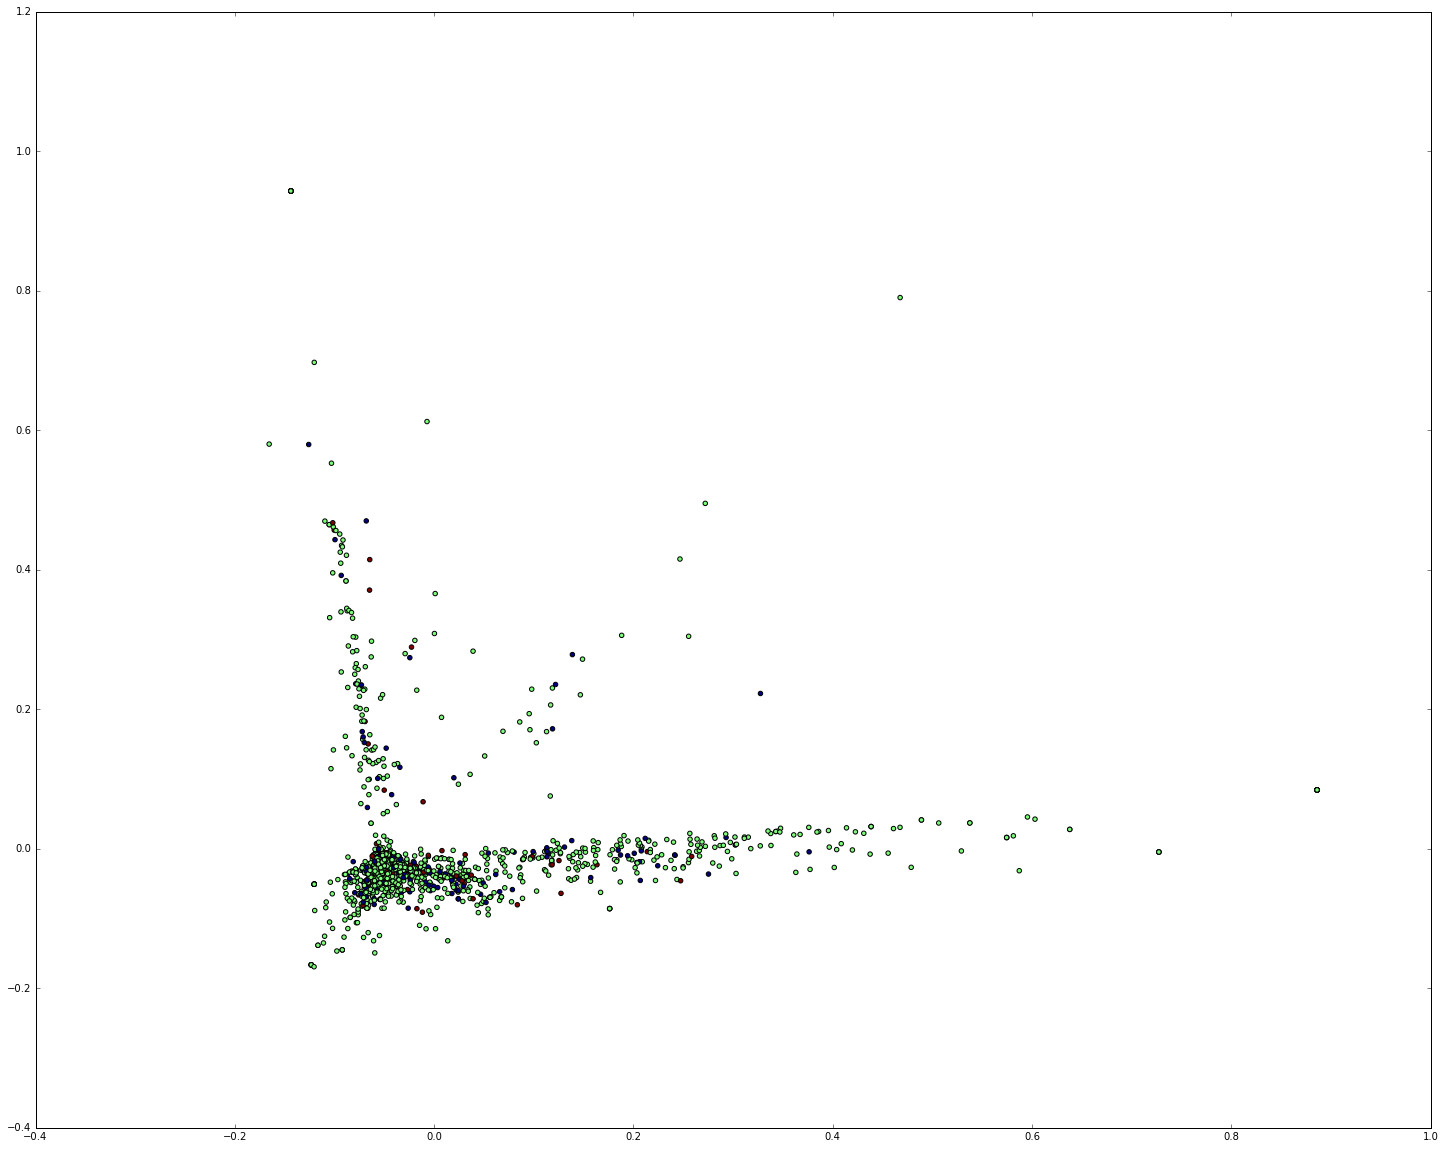

In [185]:
plt.figure(figsize=(25,20))
plt.scatter(pcar3.T[0], pcar3.T[1], c=cluster_ids)

(700,)

In [182]:
pca = PCA(n_components=3)
%time pcar = pca.fit_transform(vectorize(data_test))

CPU times: user 4.67 s, sys: 380 ms, total: 5.05 s
Wall time: 2.2 s


In [27]:
def preprocess_unlabeled_test(data):
    data.columns = ["sentence"]
    
    morph = pymorphy2.MorphAnalyzer()
    
    stem_sentence = lambda x: list(map(lambda x: morph.parse(x)[0].normal_form, x))
    lower_sentence = lambda x: list(map(lambda x: x.lower(), x))
    
    data.sentence = list(map(lambda x: re.sub("[^А-Яа-я]", " ", x), data.sentence))
    data.sentence = list(map(lambda x: re.sub("[ё]", "е", x), data.sentence))
    data.sentence = list(map(lambda x: x.split(), data.sentence))
    data.sentence = list(map(lower_sentence, data.sentence))
    data.sentence = list(map(stem_sentence, data.sentence))
    
    data["label"] = np.zeros((data.shape[0], ), dtype=np.int8) - 1
    
    return data

In [28]:
def make_csv(cluster_ids):
    unlabel = lambda x: {0: 'negative', 1: 'neutral', 2: 'positive'}.get(x)
    pred = pd.DataFrame(list(map(unlabel, cluster_ids)), columns=["label"])
    #pred["label"] = list(map(lambda x: "\"" + x + "\"", pred["label"]))
    pred.to_csv("answer.csv", index=False)

In [176]:
lr = LogisticRegression(C=1e5)

In [177]:
lr.fit(lrpca, Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [135]:
rf = RandomForestClassifier(n_estimators=1000)

In [136]:
rf.fit(rfpca, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [186]:
cluster_ids = lr.predict(lrpca)

In [149]:
data_test = pd.read_csv("/Users/alexajax/Downloads/dataset_38921_3.txt")

In [150]:
data_test = preprocess_unlabeled_test(data_test)

In [165]:
make_csv(cluster_ids)

In [164]:
cluster_ids

array([1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 1, 1, 2,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
       2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2,
       1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 2, 0,
       2, 2, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 0,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 1, 0,
       1, 0,